In [1]:
import torch
import sys
import numpy as np
import pandas as pd
import scanpy.api as sc
import scanpy
import anndata as ann
from anndata import AnnData
from matplotlib import pyplot as plt

sys.path.append("../")
from pathlib import Path
from args_parser import get_parser
import os
import json
import pickle
from model.mars import MARS
from model.experiment_dataset import ExperimentDataset
# from data.benchmarks import BenchmarkData
import warnings
warnings.filterwarnings('ignore')

sys.path.append("../")
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/CMPT415/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [2]:
def read_data(path, tissue, stats=False):
    path = Path(path)
    #pd.read_csv(path/tissue).transpose().to_csv(path/'temp.csv', header=False)
    #anndata = ann.read_csv(path/'temp.csv')
    #os.remove(path/'temp.csv')
    anndata = ann.read_csv(path/tissue)

    anndata.obs['barcode'] = anndata.obs.index

    annotations = pd.read_csv(Path(path.parent, 'annotations_facs.csv'))
    annotations.index = annotations.cell
    cell_ontology_dict = annotations['cell_ontology_class'].to_dict()
    anndata.obs['celltype'] = anndata.obs.index.map(cell_ontology_dict)
    n_cells = anndata.shape[0]
    anndata = anndata[~anndata.obs.celltype.isna()]
    n_annotated_cells = anndata.shape[0]

    anndata.var_names_make_unique(join="-")

    if stats:
        return anndata, {'n_cells': n_cells, 'n_annotated_cells': n_annotated_cells}
    else:
        return anndata

In [3]:
def preprocess_data(adata: ann.AnnData, scale :bool=True):
    """Preprocessing dataset: filtering genes/cells, normalization and scaling."""
    sc.pp.filter_cells(adata, min_counts=5000)
    sc.pp.filter_cells(adata, min_genes=500)

    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    adata.raw = adata

    sc.pp.log1p(adata)
    if scale:
        sc.pp.scale(adata, max_value=10, zero_center=True)
        adata.X[np.isnan(adata.X)] = 0

    return adata

In [4]:
# Test for marker gene overlap
gene_db = pd.read_csv('../data/PanglaoDB_markers_27_Mar_2020.tsv', sep='\t')
marker_genes = {cell: {gene for gene in gene_db[gene_db['cell type'] == cell]['official gene symbol']}  for cell in gene_db['cell type']}

In [35]:
tissue = 'trachea'

In [36]:
adata_o = ann.read_h5ad(tissue+'.h5ad')

In [37]:
f = open('resultsJSON/'+tissue+'.json')
tissue_json = json.load(f)

In [38]:
rev_dict = {value : key for (key, value) in tissue_json['celltype_dict'].items()}

In [39]:
adata_mars = AnnData(adata_o.obsm['MARS_embedding'])
adata_mars.obs['MARS_labels'] = pd.Categorical(adata_o.obs['MARS_labels'].replace(tissue_json['cluster_names']))
adata_mars.obs['ground_truth'] = pd.Categorical(adata_o.obs['truth_labels'].replace(rev_dict))
adata_mars.obs['experiment'] = pd.Categorical(adata_o.obs['experiment'])

In [40]:
tissue_mars = adata_mars[adata_mars.obs['experiment'] == tissue,:]
sc.pp.neighbors(tissue_mars, n_neighbors=30, use_rep='X')
sc.tl.umap(tissue_mars)

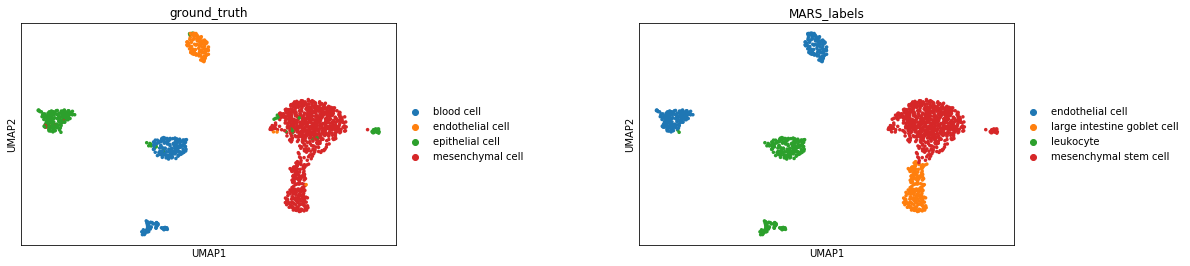

In [41]:
sc.pl.umap(tissue_mars, color=['ground_truth','MARS_labels'],size=50, wspace=0.5, save=tissue+'.png')

# Gene Overlap

In [27]:
# Capitalize all gene names

for i in range(len(adata_o.uns['rank_genes_groups']['names'])):
    for j in range(len(adata_o.uns['rank_genes_groups']['names'][i])):
        adata_o.uns['rank_genes_groups']['names'][i][j] = adata_o.uns['rank_genes_groups']['names'][i][j].upper()

adata_o.uns['rank_genes_groups']['names']

array([('LY6D', 'KRT5', 'MIR881'), ('RAB25', 'FTH1', 'GM15114'),
       ('MT4', 'IGFBP2', 'GM5635'),
       ('LGALS3', 'COL17A1', '2310001H18RIK'),
       ('LYPD3', 'CRIP1', 'RPRL3'), ('FABP5', 'S100A10', 'VMN1R198'),
       ('DMKN', 'FTL1', 'MIR873'), ('GLTP', 'S100A6', 'VMN1R117'),
       ('CYP4F39', 'KRT15', 'MIR878'), ('PERP', 'ITGB4', 'MIR883A'),
       ('RNH1', 'PTRF', 'MIR3108'), ('S100A16', 'KRT14', 'MIR129-1'),
       ('CDKN1A', 'TMSB4X', 'AMY2A5'), ('CALML3', 'CCND2', 'MIR486'),
       ('SULT2B1', 'LAMB3', 'MIR135B'), ('DBI', 'BCAM', 'OMT2B'),
       ('AQP3', 'TSPO', '4930444G20RIK'),
       ('CALM4', 'WNT10A', 'GFP_TRANSGENE'), ('EMP2', 'HMGB1', 'MIR693'),
       ('TGM1', 'SLC6A6', 'DEFB43'),
       ('ALDH3B2', '1700111N16RIK', 'RPL10L'),
       ('RHOV', 'MOXD1', 'MIR676'), ('PDLIM2', 'APOE', 'KRTAP1-3'),
       ('GSN', 'OLFR809', 'VMN1R226'), ('SFN', 'WFDC2', 'LCE1I'),
       ('S100A14', 'IGFBP7', 'OLFR1193'),
       ('JUP', 'ERCC-00012', 'OLFR922'),
       ('PYCARD', 'B230

In [28]:
marker_matches = scanpy.tl.marker_gene_overlap(adata_o, marker_genes)
marker_matches = marker_matches.rename(tissue_json['cluster_names'], axis=1)
marker_matches.to_csv('MatchCSVs/' + tissue + '.csv')

In [29]:
marker_matches

,type B pancreatic cell,epithelial cell of large intestine,nan
Acinar cells,0.0,0.0,1.0
Adipocyte progenitor cells,0.0,0.0,0.0
Adipocytes,1.0,1.0,0.0
Adrenergic neurons,0.0,0.0,0.0
Airway epithelial cells,0.0,0.0,0.0
Airway goblet cells,0.0,1.0,0.0
Airway smooth muscle cells,0.0,0.0,0.0
Alpha cells,0.0,0.0,0.0
Alveolar macrophages,0.0,0.0,0.0
Anterior pituitary gland cells,0.0,0.0,0.0


# Analyze Marker Matches

In [30]:
#Read in CSV here if needed
marker_matches = pd.read_csv('MatchCSVs/' + tissue + '.csv', index_col='Unnamed: 0')

In [31]:
marker_matches

,type B pancreatic cell,epithelial cell of large intestine,nan
Acinar cells,0.0,0.0,1.0
Adipocyte progenitor cells,0.0,0.0,0.0
Adipocytes,1.0,1.0,0.0
Adrenergic neurons,0.0,0.0,0.0
Airway epithelial cells,0.0,0.0,0.0
Airway goblet cells,0.0,1.0,0.0
Airway smooth muscle cells,0.0,0.0,0.0
Alpha cells,0.0,0.0,0.0
Alveolar macrophages,0.0,0.0,0.0
Anterior pituitary gland cells,0.0,0.0,0.0


In [32]:
overlap_dict = {}
for col in marker_matches.columns:
    temp = marker_matches.sort_values(by=[col], ascending=False).head(3)
    overlap_dict[col] = {row: temp.loc[row][col] for row in temp.index}
#     print(temp.index)

In [33]:
overlap_dict

{'type B pancreatic cell': {'Keratinocytes': 9.0,
  'Epithelial cells': 4.0,
  'Principal cells': 3.0},
 'epithelial cell of large intestine': {'Basal cells': 5.0,
  'Epithelial cells': 4.0,
  'Myoepithelial cells': 3.0},
 'nan': {'Acinar cells': 1.0, 'Basophils': 1.0, 'T helper cells': 1.0}}

In [34]:
del adata_o

In [38]:
set(marker_genes)

{'Acinar cells',
 'Adipocyte progenitor cells',
 'Adipocytes',
 'Adrenergic neurons',
 'Airway epithelial cells',
 'Airway goblet cells',
 'Airway smooth muscle cells',
 'Alpha cells',
 'Alveolar macrophages',
 'Anterior pituitary gland cells',
 'Astrocytes',
 'B cells',
 'B cells memory',
 'B cells naive',
 'Basal cells',
 'Basophils',
 'Bergmann glia',
 'Beta cells',
 'Cajal-Retzius cells',
 'Cardiac stem and precursor cells',
 'Cardiomyocytes',
 'Cholangiocytes',
 'Cholinergic neurons',
 'Chondrocytes',
 'Choroid plexus cells',
 'Chromaffin cells',
 'Ciliated cells',
 'Clara cells',
 'Crypt cells',
 'Decidual cells',
 'Delta cells',
 'Dendritic cells',
 'Distal tubule cells',
 'Dopaminergic neurons',
 'Ductal cells',
 'Embryonic stem cells',
 'Endothelial cells',
 'Endothelial cells (aorta)',
 'Endothelial cells (blood brain barrier)',
 'Enteric glia cells',
 'Enteric neurons',
 'Enterochromaffin cells',
 'Enterocytes',
 'Enteroendocrine cells',
 'Eosinophils',
 'Ependymal cells',
 